# Label Analysis - Legal Text Decoder

This notebook analyzes the label distribution, class imbalance, and potential patterns in the annotations.

Key questions:
- How imbalanced are the classes?
- Are there annotator biases across different data sources?
- What class weights should we use for training?

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# Load data
with open('../data/processed/all_data.json', 'r', encoding='utf-8') as f:
    all_data = json.load(f)

df = pd.DataFrame(all_data)
df['text_length'] = df['text'].str.len()

# Label names
label_names = {
    1: 'Very Hard',
    2: 'Hard',
    3: 'Moderate',
    4: 'Easy',
    5: 'Very Easy'
}

print(f"Total samples: {len(df)}")

Total samples: 3397


## 1. Class Imbalance Analysis

In [3]:
# Calculate class imbalance metrics
label_counts = df['label'].value_counts().sort_index()
total = len(df)

print("Class Distribution:")
print("="*50)
for label in sorted(label_counts.index):
    count = label_counts[label]
    pct = 100 * count / total
    print(f"  Label {label} ({label_names[label]:10}): {count:4d} samples ({pct:5.1f}%)")

# Imbalance ratio
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")
print(f"Majority class: Label {label_counts.idxmax()} ({label_names[label_counts.idxmax()]})")
print(f"Minority class: Label {label_counts.idxmin()} ({label_names[label_counts.idxmin()]})")

Class Distribution:
  Label 1 (Very Hard ):  176 samples (  5.2%)
  Label 2 (Hard      ):  392 samples ( 11.5%)
  Label 3 (Moderate  ):  721 samples ( 21.2%)
  Label 4 (Easy      ): 1022 samples ( 30.1%)
  Label 5 (Very Easy ): 1086 samples ( 32.0%)

Imbalance Ratio (max/min): 6.17
Majority class: Label 5 (Very Easy)
Minority class: Label 1 (Very Hard)


Recommended Class Weights (balanced):
  Label 1 (Very Hard ): 3.8602
  Label 2 (Hard      ): 1.7332
  Label 3 (Moderate  ): 0.9423
  Label 4 (Easy      ): 0.6648
  Label 5 (Very Easy ): 0.6256


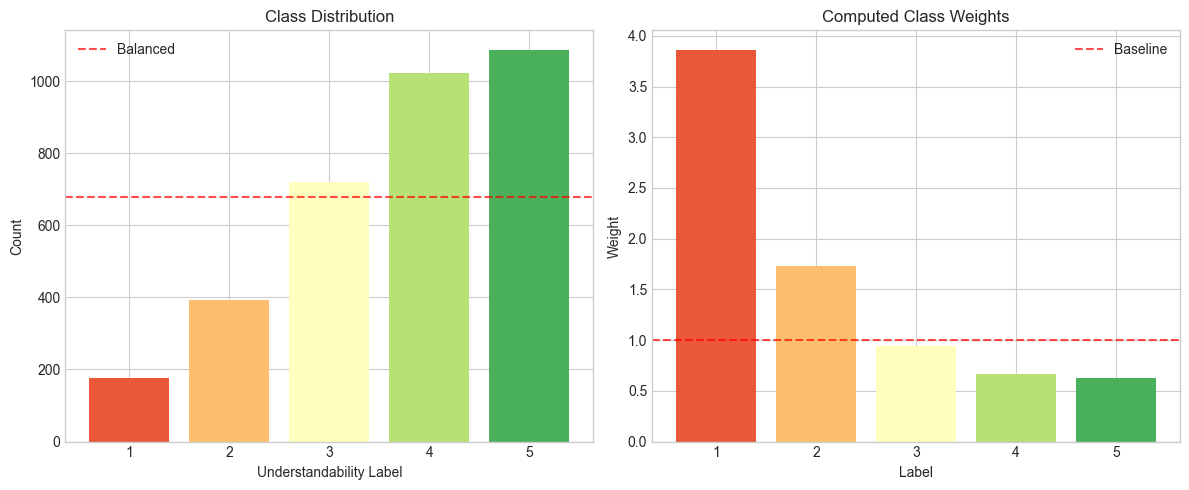

In [4]:
# Calculate class weights for training
labels = df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i+1: w for i, w in enumerate(class_weights)}

print("Recommended Class Weights (balanced):")
print("="*50)
for label in sorted(class_weight_dict.keys()):
    weight = class_weight_dict[label]
    print(f"  Label {label} ({label_names[label]:10}): {weight:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Class distribution
colors = sns.color_palette('RdYlGn', 5)
axes[0].bar(label_counts.index, label_counts.values, color=colors)
axes[0].set_xlabel('Understandability Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].axhline(y=total/5, color='red', linestyle='--', alpha=0.7, label='Balanced')
axes[0].legend()

# Class weights
weight_values = [class_weight_dict[i] for i in range(1, 6)]
axes[1].bar(range(1, 6), weight_values, color=colors)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Weight')
axes[1].set_title('Computed Class Weights')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[1].legend()

plt.tight_layout()
plt.savefig('../notebook/class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Annotator Bias Analysis

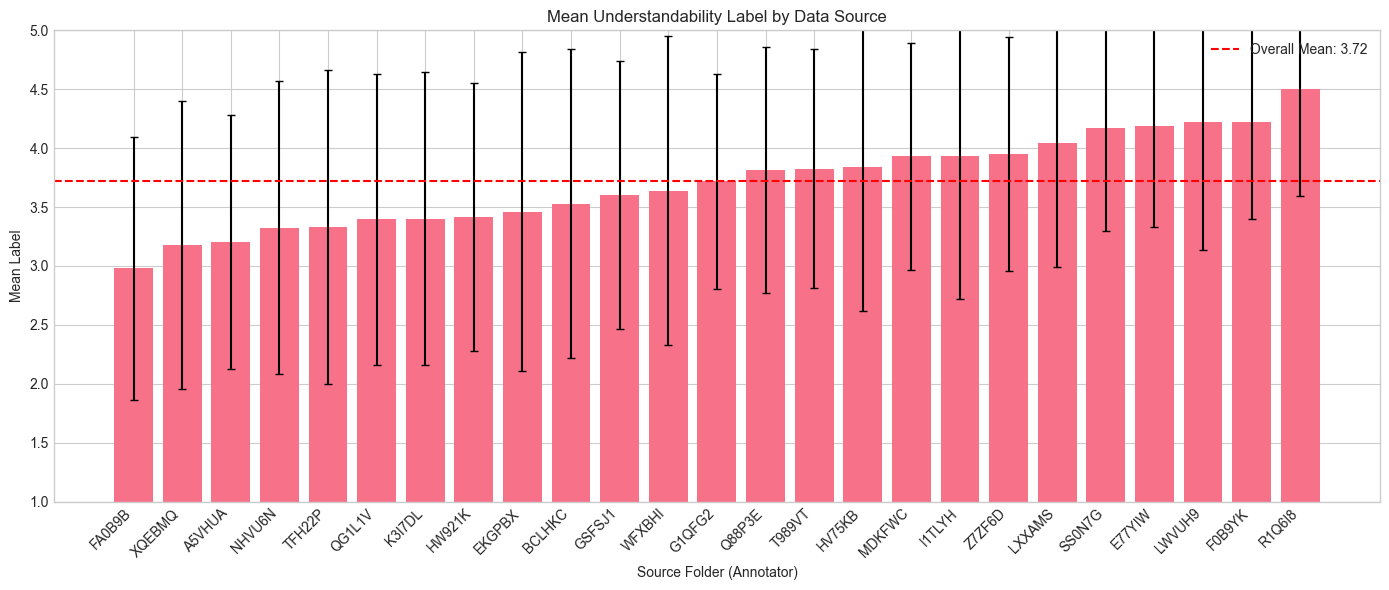


Overall mean label: 3.721
Std of mean labels across sources: 0.391


In [5]:
# Mean label per source folder (annotator tendency)
mean_label_by_source = df.groupby('source_folder')['label'].agg(['mean', 'std', 'count']).sort_values('mean')

plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(mean_label_by_source)), mean_label_by_source['mean'])
plt.errorbar(range(len(mean_label_by_source)), mean_label_by_source['mean'], 
             yerr=mean_label_by_source['std'], fmt='none', color='black', capsize=3)
plt.xticks(range(len(mean_label_by_source)), mean_label_by_source.index, rotation=45, ha='right')
plt.xlabel('Source Folder (Annotator)')
plt.ylabel('Mean Label')
plt.title('Mean Understandability Label by Data Source')
plt.axhline(y=df['label'].mean(), color='red', linestyle='--', label=f'Overall Mean: {df["label"].mean():.2f}')
plt.legend()
plt.ylim(1, 5)
plt.tight_layout()
plt.savefig('../notebook/annotator_bias.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOverall mean label: {df['label'].mean():.3f}")
print(f"Std of mean labels across sources: {mean_label_by_source['mean'].std():.3f}")

In [6]:
# Chi-square test for independence between source and label
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['source_folder'], df['label'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for source-label independence:")
print(f"  Chi-square statistic: {chi2:.2f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_value:.2e}")
print(f"\nInterpretation: {'Significant dependency' if p_value < 0.05 else 'No significant dependency'} between source and label")

Chi-square test for source-label independence:
  Chi-square statistic: 456.33
  Degrees of freedom: 96
  P-value: 2.72e-48

Interpretation: Significant dependency between source and label


## 3. Text Length vs Label Correlation

Correlation between text length and label:
  Pearson:  r = -0.3815, p = 3.9050e-118
  Spearman: ρ = -0.5110, p = 1.9699e-225


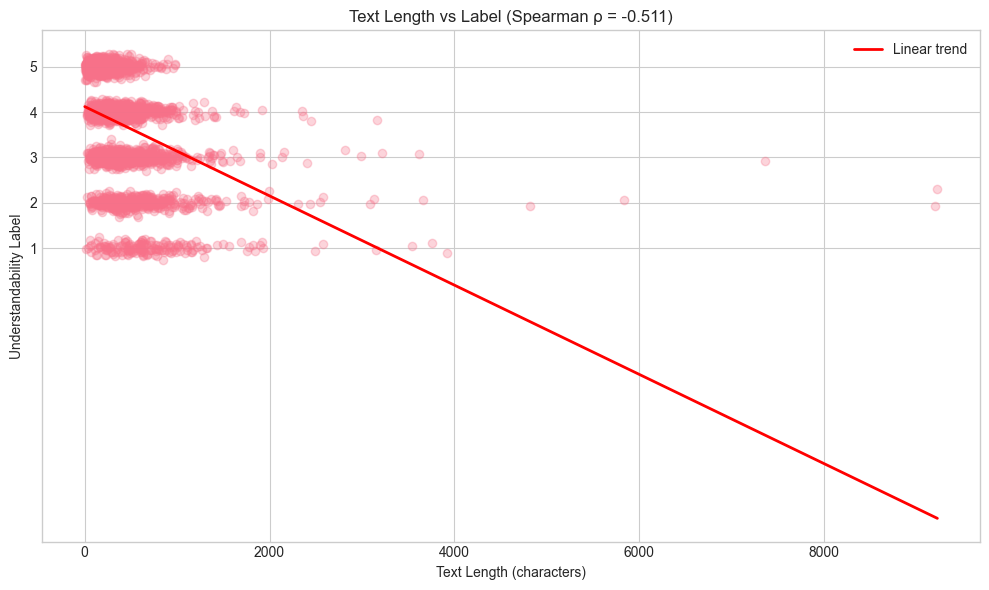

In [7]:
# Correlation between text length and label
from scipy.stats import spearmanr, pearsonr

pearson_corr, pearson_p = pearsonr(df['text_length'], df['label'])
spearman_corr, spearman_p = spearmanr(df['text_length'], df['label'])

print("Correlation between text length and label:")
print(f"  Pearson:  r = {pearson_corr:.4f}, p = {pearson_p:.4e}")
print(f"  Spearman: ρ = {spearman_corr:.4f}, p = {spearman_p:.4e}")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['label'] + np.random.normal(0, 0.1, len(df)), alpha=0.3)
plt.xlabel('Text Length (characters)')
plt.ylabel('Understandability Label')
plt.title(f'Text Length vs Label (Spearman ρ = {spearman_corr:.3f})')
plt.yticks([1, 2, 3, 4, 5])

# Add trend line
z = np.polyfit(df['text_length'], df['label'], 1)
p = np.poly1d(z)
x_range = np.linspace(df['text_length'].min(), df['text_length'].max(), 100)
plt.plot(x_range, p(x_range), 'r-', linewidth=2, label='Linear trend')
plt.legend()

plt.tight_layout()
plt.savefig('../notebook/length_vs_label.png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

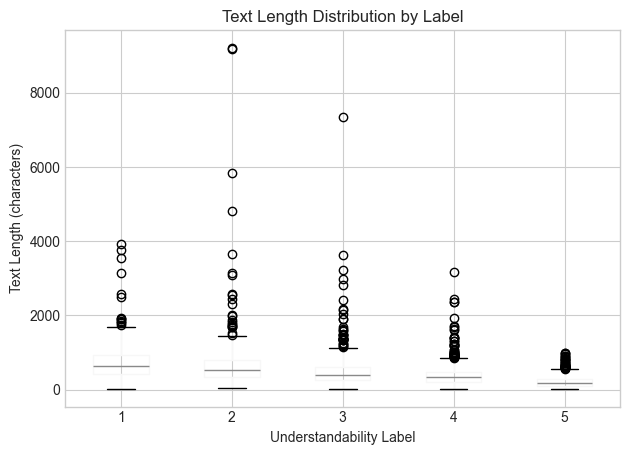


Mean text length by label:
  Label 1: mean=768, median=626
  Label 2: mean=692, median=519
  Label 3: mean=495, median=398
  Label 4: mean=378, median=327
  Label 5: mean=209, median=178


In [8]:
# Box plot of text length by label
plt.figure(figsize=(10, 6))
df.boxplot(column='text_length', by='label')
plt.xlabel('Understandability Label')
plt.ylabel('Text Length (characters)')
plt.title('Text Length Distribution by Label')
plt.suptitle('')
plt.tight_layout()
plt.savefig('../notebook/length_boxplot_by_label.png', dpi=150, bbox_inches='tight')
plt.show()

# Mean length per label
print("\nMean text length by label:")
for label in sorted(df['label'].unique()):
    mean_len = df[df['label'] == label]['text_length'].mean()
    median_len = df[df['label'] == label]['text_length'].median()
    print(f"  Label {label}: mean={mean_len:.0f}, median={median_len:.0f}")

## 4. Ordinal Label Analysis

In [9]:
# Confusion patterns - for ordinal data, errors between adjacent classes are "better"
# Let's analyze the ordinal nature of labels

# Adjacent label pairs
print("Adjacent class boundaries:")
for i in range(1, 5):
    count_lower = label_counts[i]
    count_upper = label_counts[i+1]
    boundary_samples = count_lower + count_upper
    print(f"  {i} ↔ {i+1}: {boundary_samples} samples ({100*boundary_samples/total:.1f}%)")

# This helps understand where ordinal loss might be most beneficial

Adjacent class boundaries:
  1 ↔ 2: 568 samples (16.7%)
  2 ↔ 3: 1113 samples (32.8%)
  3 ↔ 4: 1743 samples (51.3%)
  4 ↔ 5: 2108 samples (62.1%)



Cumulative Distribution:
  P(label ≤ 1): 5.2%
  P(label ≤ 2): 16.7%
  P(label ≤ 3): 37.9%
  P(label ≤ 4): 68.0%
  P(label ≤ 5): 100.0%


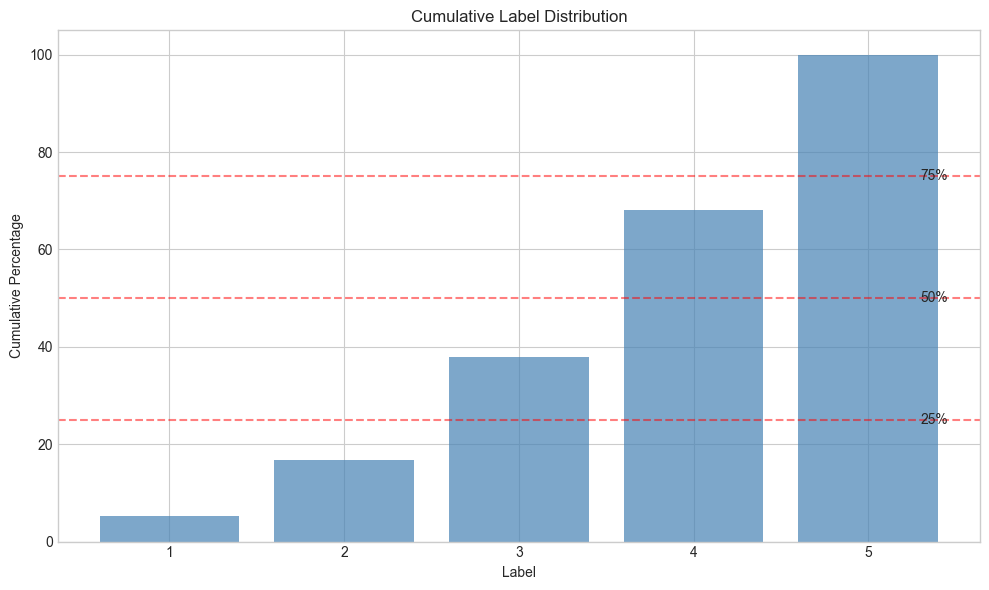

In [10]:
# Cumulative distribution - useful for ordinal regression perspective
cumulative_counts = label_counts.sort_index().cumsum()
cumulative_pct = 100 * cumulative_counts / total

print("\nCumulative Distribution:")
print("="*50)
for label in sorted(label_counts.index):
    print(f"  P(label ≤ {label}): {cumulative_pct[label]:.1f}%")

# Visualize cumulative distribution
plt.figure(figsize=(10, 6))
plt.bar(cumulative_counts.index, cumulative_pct.values, alpha=0.7, color='steelblue')
plt.xlabel('Label')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Label Distribution')
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0, 105)

# Add horizontal lines at key percentiles
for pct in [25, 50, 75]:
    plt.axhline(y=pct, color='red', linestyle='--', alpha=0.5)
    plt.text(5.3, pct, f'{pct}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../notebook/cumulative_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary and Recommendations

In [11]:
print("="*60)
print("LABEL ANALYSIS SUMMARY")
print("="*60)

print(f"\n1. CLASS IMBALANCE:")
print(f"   - Imbalance ratio: {imbalance_ratio:.2f}x")
print(f"   - Minority class (Label 1): {label_counts[1]} samples ({100*label_counts[1]/total:.1f}%)")
print(f"   - Majority classes (Labels 4,5): {label_counts[4]+label_counts[5]} samples ({100*(label_counts[4]+label_counts[5])/total:.1f}%)")

print(f"\n2. ANNOTATOR VARIATION:")
print(f"   - Mean label varies from {mean_label_by_source['mean'].min():.2f} to {mean_label_by_source['mean'].max():.2f} across sources")
print(f"   - Chi-square p-value: {p_value:.2e} ({'Significant' if p_value < 0.05 else 'Not significant'} source effect)")

print(f"\n3. TEXT LENGTH CORRELATION:")
print(f"   - Spearman correlation: {spearman_corr:.4f}")
print(f"   - {'Negative' if spearman_corr < 0 else 'Positive'} correlation: longer texts tend to be rated as {'harder' if spearman_corr < 0 else 'easier'}")

print(f"\n4. RECOMMENDATIONS:")
print(f"   - Use class weights during training to handle imbalance")
print(f"   - Ordinal cross-entropy loss is appropriate given the ordinal nature of labels")
print(f"   - Consider text length as a potential feature or confound")

print(f"\n5. CLASS WEIGHTS FOR TRAINING:")
for label in sorted(class_weight_dict.keys()):
    print(f"   Label {label}: {class_weight_dict[label]:.4f}")

LABEL ANALYSIS SUMMARY

1. CLASS IMBALANCE:
   - Imbalance ratio: 6.17x
   - Minority class (Label 1): 176 samples (5.2%)
   - Majority classes (Labels 4,5): 2108 samples (62.1%)

2. ANNOTATOR VARIATION:
   - Mean label varies from 2.98 to 4.50 across sources
   - Chi-square p-value: 2.72e-48 (Significant source effect)

3. TEXT LENGTH CORRELATION:
   - Spearman correlation: -0.5110
   - Negative correlation: longer texts tend to be rated as harder

4. RECOMMENDATIONS:
   - Use class weights during training to handle imbalance
   - Ordinal cross-entropy loss is appropriate given the ordinal nature of labels
   - Consider text length as a potential feature or confound

5. CLASS WEIGHTS FOR TRAINING:
   Label 1: 3.8602
   Label 2: 1.7332
   Label 3: 0.9423
   Label 4: 0.6648
   Label 5: 0.6256


In [12]:
# Save class weights for use in training
import json

weights_config = {
    'class_weights': class_weight_dict,
    'imbalance_ratio': imbalance_ratio,
    'label_counts': {int(k): int(v) for k, v in label_counts.items()},
    'mean_label': float(df['label'].mean()),
    'text_length_correlation': float(spearman_corr)
}

with open('../data/processed/label_analysis.json', 'w') as f:
    json.dump(weights_config, f, indent=2)

print("Label analysis saved to data/processed/label_analysis.json")

Label analysis saved to data/processed/label_analysis.json
